# Virtual Concierge 

## Face Recognition Project with MXNet

***
Copyright [2017]-[2018] Amazon.com, Inc. or its affiliates. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"). You may not use this file except in compliance with the License. A copy of the License is located at

http://aws.amazon.com/apache2.0/

or in the "license" file accompanying this file. This file is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
***

### Prerequisites:

#### Python package dependencies

The following packages need to be installed before proceeding:

* Boto3 - `pip install boto3`
* MXNet - `pip install mxnet`
* numpy - `pip install numpy`
* OpenCV - `pip install opencv-python`
* Graphviz - `pip install graphviz`
* Matplotlib - `pip install matplotlib`
* Seaborn - `pip install seaborn`

### Import dependencies

Verify that all dependencies are installed using the cell below. Continue if no errors encountered, warnings can be ignored.

In [1]:
from __future__ import print_function

import boto3
import cv2
import sys
import numpy as np
import mxnet as mx
import os
import json
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns 

%matplotlib inline

### Load pretrained model

`get_model()` : Loads MXNet symbols and params, defines model using symbol file and binds parameters to the model using params file.

In [2]:
def get_model(ctx, image_size, model_str, layer):
    _vec = model_str.split(',')
    assert len(_vec)==2
    prefix = _vec[0]
    epoch = int(_vec[1])
    print('loading',prefix, epoch)
    sym, arg_params, aux_params = mx.model.load_checkpoint(prefix, epoch)
    all_layers = sym.get_internals()
    sym = all_layers[layer+'_output']
    model = mx.mod.Module(symbol=sym, context=ctx, label_names = None)
    model.bind(data_shapes=[('data', (1, 3, image_size[0], image_size[1]))])
    model.set_params(arg_params, aux_params)
    return model, sym

### Preprocess images

In order to input only face pixels into the network, all input images are passed through a pretrained face detection and alignment model as described above. The output of this model are landmark points and a bounding box corresponding to the face in the image. Using this output, the image is processed using affine transforms to generate the aligned face images which are input to the network. The functions performing this is defined below.

`get_input()` : Returns aligned face to the bbox and margin, and [rotation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html)

`show_input()` : Shows the image after transposing it

In [3]:
def get_input(img, image_size, bbox=None, margin=0, rotate=0):
    if bbox is None:
        det = np.zeros(4, dtype=np.int32)
        det[0] = int(img.shape[1]*0.0625)
        det[1] = int(img.shape[0]*0.0625)
        det[2] = img.shape[1] - det[0]
        det[3] = img.shape[0] - det[1]
    else:
        det = bbox
    # Crop
    bb = np.zeros(4, dtype=np.int32)
    bb[0] = np.maximum(det[0]-margin/2, 0)
    bb[1] = np.maximum(det[1]-margin/2, 0)
    bb[2] = np.minimum(det[2]+margin/2, img.shape[1])
    bb[3] = np.minimum(det[3]+margin/2, img.shape[0])
    img = img[bb[1]:bb[3],bb[0]:bb[2],:]
    # Rotate if required
    if 0 < rotate and rotate < 360:
        rows,cols,_ = img.shape
        M = cv2.getRotationMatrix2D((cols/2,rows/2),360-rotate,1)
        img = cv2.warpAffine(img,M,(cols,rows))
    # Resize and transform
    img = cv2.resize(img, (image_size[1], image_size[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    aligned = np.transpose(img, (2,0,1))
    return aligned

def show_input(aligned):
    plt.imshow(np.transpose(aligned,(1,2,0)))

### Get Features

`l2_normalize()`: Performs row normalization on the vector

`get_feature()` : Performs forward pass on the data aligned using model and returns the embedding

In [4]:
def l2_normalize(X):
    norms = np.sqrt((X * X).sum(axis=1))
    X /= norms[:, np.newaxis]
    return X

def get_feature(model, aligned):
    input_blob = np.expand_dims(aligned, axis=0)
    data = mx.nd.array(input_blob)
    db = mx.io.DataBatch(data=(data,))
    model.forward(db, is_train=False)
    embedding = model.get_outputs()[0].asnumpy()
    embedding = l2_normalize(embedding).flatten()
    return embedding

### Visualize Model

Load the pre-trained mobilenet mobile, setting the context to cpu and visualize the architecture.

In [5]:
%%time

image_size = (112,112)
model_name = './models/mobilenet1,0'
model, sym = get_model(mx.cpu(), image_size, model_name, 'fc1')

loading ./models/mobilenet1 0
CPU times: user 103 ms, sys: 17.2 ms, total: 121 ms
Wall time: 87.3 ms


In [6]:
mx.viz.plot_network(sym)

### Evaulate

Download sample image, and extract face coordinates

In [7]:
!aws s3 cp s3://aiml-lab-sagemaker/politicians/politicians2.jpg tmp/image

download: s3://aiml-lab-sagemaker/politicians/politicians2.jpg to tmp/image


In [8]:
rekognition = boto3.client('rekognition')

def get_bboxes(img, margin=0):
    # Detect faces
    ret, buf = cv2.imencode('.jpg', img)
    ret = rekognition.detect_faces(
        Image={
            'Bytes': buf.tobytes()
        },
        Attributes=['DEFAULT'],
    )
    # Return the bounding boxes for each face
    height, width, _ = img.shape
    bboxes = []
    for face in ret['FaceDetails']:
        box = face['BoundingBox']
        x1 = int(box['Left'] * width)
        y1 = int(box['Top'] * height)
        x2 = int(box['Left'] * width + box['Width'] * width)
        y2 = int(box['Top'] * height + box['Height']  * height)
        bboxes.append((x1, y1, x2, y2))
    return bboxes

For each of the coordinates, get a the aligned image, and draw the rectangle

CPU times: user 51.3 ms, sys: 3.93 ms, total: 55.2 ms
Wall time: 1.38 s


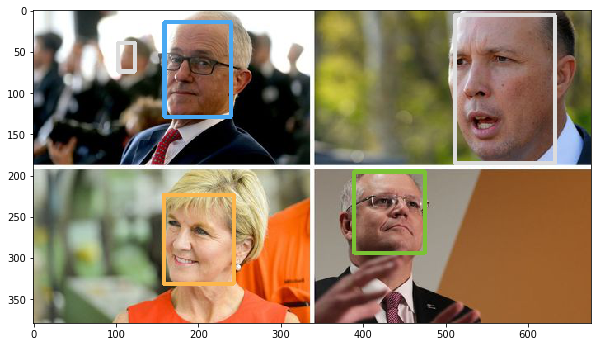

In [9]:
%%time

# Load the image, and get bboxes
img = cv2.imread('tmp/image')
boxes = get_bboxes(img)

# blue, green, red, grey
colors = ((220,220,220),(242,168,73),(76,182,252),(52,194,123))

img_aligned = []
for col, bbox in enumerate(boxes): 
    aligned = get_input(img, image_size, bbox)
    img_aligned.append(aligned)
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), colors[col%4], 3)
    
# Plot the figure in it's original rotation
plt.figure(figsize=(10,10))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

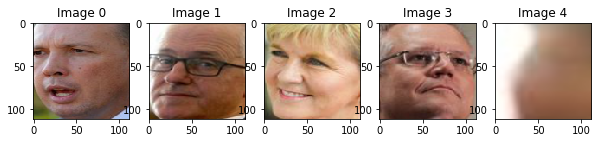

In [10]:
# output the aligned image
fig = plt.figure(figsize=(10,10))
for i, aligned in enumerate(img_aligned):
    a = fig.add_subplot(1, len(img_aligned), i+1)
    a.set_title('Image {}'.format(i))
    show_input(aligned)
plt.show()

### Generate embedding

Pass each face through the network sequentially to generate embedding vectors for each. 

In [11]:
img_vecs = np.array([get_feature(model, aligned) for aligned in img_aligned])
print(img_vecs.shape)
img_vecs[0]

(5, 128)


array([-0.10454902, -0.04392235,  0.07074911,  0.04567999,  0.02645712,
        0.04673402, -0.15382035,  0.07499488,  0.09955145, -0.05470199,
        0.0265877 , -0.12774347,  0.09289423, -0.04567178, -0.00610453,
        0.01764223, -0.08242195,  0.09871089, -0.10027214, -0.05725274,
       -0.00837896,  0.04182326, -0.08193921,  0.08994235, -0.05702268,
        0.0808086 ,  0.01633173,  0.05331945,  0.00311425, -0.08266096,
       -0.04185392,  0.09735581, -0.00958765,  0.13216823, -0.01836975,
        0.00321934, -0.1384796 ,  0.08913795,  0.06268549,  0.03472007,
       -0.05867929,  0.08904128, -0.01627143, -0.15471555,  0.15073729,
       -0.10684767,  0.12687935,  0.18126649, -0.03018706, -0.12042397,
        0.05387223,  0.03341911, -0.14620636, -0.0814472 , -0.18163261,
       -0.03739975, -0.03634822, -0.07585021, -0.0250113 , -0.04051198,
        0.04077457,  0.03932738,  0.04546115, -0.01962021, -0.00797752,
        0.11064401, -0.01597885, -0.00335919, -0.07099593,  0.07

### Calculate similarity

Calculate the cosine similarity between the embedding vectors to see how similar they are to each out. 

Similarity values in [-1,1].

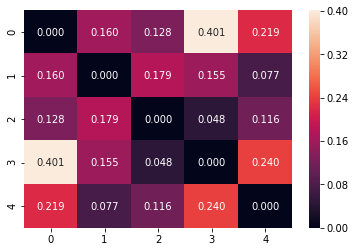

In [12]:
sims = np.dot(img_vecs, img_vecs.T)
np.fill_diagonal(sims, 0)
sns.heatmap(sims, annot=True, fmt=".03f")

### Vectorize Dataset

Download a the politician dataset, and vectories the images.

In [13]:
!mkdir -p tmp/images
!aws s3 sync s3://aiml-lab-sagemaker/actors/ tmp/images

In [ ]:
%%time

image_dir = 'tmp/images'
names = []
vecs = []

for file in os.listdir(image_dir):
    name = file.split('.')[0]
    img = cv2.imread(os.path.join(image_dir, file))
    bboxes = get_bboxes(img)
    bbox = bboxes[0]
    print(name, bbox)
    aligned = get_input(img, image_size, bbox)
    vec = get_feature(model, aligned)   
    names.append(name)
    vecs.append(vec)
    
vecs = np.array(vecs)

Save the vectors back to a file with the names.

In [ ]:
np.savez('people.npz', names=names, vecs=vecs)

### Plot Distribution

Compare the vectors of all the politications to input image, plot the distribution and outliner for match.

In [ ]:
img = img_vecs[0]

# calculate cosine similarity and relative zscores
sims = np.dot(vecs, img)
zscores = stats.zscore(sims)

# plot series and print score and name
sns.set(color_codes=True)
plt.figure(figsize=(10,6))
ax = sns.distplot(zscores, bins=50, kde=False, rug=True)
ax.set(xlabel='zscore', ylabel='number of people')
plt.title('zscore distribution')
plt.show()

Output the name of the highest similarity based on the dataset

In [ ]:
from math import erf, sqrt
def phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    return (1.0 + erf(x / sqrt(2.0))) / 2.0

idx = sims.argmax()
print('sim: {}, zscore: {}, prob: {}, name: {}'.format(sims[idx], zscores[idx], phi(zscores[idx]), names[idx]))

## Set up hosting for the model

### Export the model from mxnet

In order to set up hosting, we have to [import the model from training to hosting](https://aws.amazon.com/blogs/machine-learning/bring-your-own-pre-trained-mxnet-or-tensorflow-models-into-amazon-sagemaker/). We will begin by exporting the model from MXNet and saving it down. The exported model has to be converted into a form that is readable by ``sagemaker.mxnet.model.MXNetModel``. The following code describes exporting the model in a form that does the same:

In [ ]:
import os
import json

os.mkdir('model')

model.save_checkpoint('model/model', 0000)
with open ('model/model-shapes.json', "w") as shapes:
    json.dump([{"shape": model.data_shapes[0][1], "name": "data"}], shapes)

import tarfile

def flatten(tarinfo):
    tarinfo.name = os.path.basename(tarinfo.name)
    return tarinfo
    
tar = tarfile.open("model.tar.gz", "w:gz")
tar.add("model", filter=flatten)
tar.close()

The above piece of code essentially hacks the MXNet model export into a sagemaker-readable model export. Study the exported model files if you want to organize your exports in the same fashion as well. Alternatively, you can load the model on MXNet itself and load the sagemaker model as you normally would. Refer [here](https://github.com/aws/sagemaker-python-sdk#model-loading) for details on how to load MXNet models.

### Import model into SageMaker

Open a new sagemaker session and upload the model on to the default S3 bucket. We can use the ``sagemaker.Session.upload_data`` method to do this. We need the location of where we exported the model from MXNet and where in our default bucket we want to store the model(``/model``). The default S3 bucket can be found using the ``sagemaker.Session.default_bucket`` method.

In [15]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = get_execution_role()
role

'arn:aws:iam::423079281568:role/service-role/AmazonSageMaker-ExecutionRole-20190107T214430'

In [16]:
model_data = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='virtual-concierge')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-423079281568


Use the ``sagemaker.mxnet.model.MXNetModel`` to import the model into SageMaker that can be deployed. We need the location of the S3 bucket where we have the model, the role for authentication and the entry_point where the model defintion is stored (``predict.py``). 

In [17]:
from sagemaker.mxnet.model import MXNetModel
sagemaker_model = MXNetModel(model_data = model_data, role = role, entry_point = 'predict.py')

### Create endpoint

Now the model is ready to be deployed at a SageMaker endpoint. We can use the ``sagemaker.mxnet.model.MXNetModel.deploy`` method to do this. Unless you have created or prefer other instances, we recommend using 1 ``'ml.c4.xlarge'`` instance for this training. These are supplied as arguments. 

In [18]:
import logging
logging.getLogger().setLevel(logging.WARNING)

predictor = sagemaker_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-423079281568
INFO:sagemaker:Creating model with name: sagemaker-mxnet-2019-03-27-03-02-20-732
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2019-03-27-03-02-20-732


----------------------------------------------------------------------------!

### Making an inference request

Now that our Endpoint is deployed and we have a ``predictor`` object which we can call for inference.

We wiill pass a single batch of an aligned image as a numpy array in the shape the model expects, setting `content_type` and `serializer` to convert into bytes.  The `predict.py` endpoint includes overides for `model_fn` to load fully connected layer and `transform_fn` to [transform](https://sagemaker.readthedocs.io/en/stable/using_mxnet.html?highlight=input_fn#using-input-fn-predict-fn-and-output-fn) to load numpy input and return normalized emeddings as json.

The SageMaker MXNet containers are [open source](https://github.com/aws/sagemaker-containers) if you needed more details.

In [19]:
!cat predict.py

def transform_fn(model, request_body, request_content_type, accept_type):
    """
    Transform a request using the Gluon model. Called once per request.
    :param model: The model.
    :param request_body: The request payload.
    :param request_content_type: The request content type.
    :param accept_type: The (desired) response content type.
    :return: response payload and content type.
    """

    import mxnet as mx
    import logging
    
    logging.info('Invoking transform Shape: {}, Content Type: {}, Accept: {}'.format(
        model.data_shapes[0][1], request_content_type, accept_type))
    
    array = neo_preprocess(request_body, request_content_type)
    
    print('input', array)

    data = mx.nd.array(array)
    db = mx.io.DataBatch(data=(data,))
    model.forward(db, is_train=False)
    output = model.get_outputs()[0].asnumpy()
    
    print('output', output)

    if accept_type == 'application/json':
        return neo_postprocess(output)
    else:
        raise 

In [20]:
# Pass last aligned input into model
input = np.expand_dims(aligned, axis=0)
input.shape

(1, 3, 112, 112)

In [21]:
def numpy_bytes_serializer(data):
    import io
    import numpy as np
    
    f = io.BytesIO()
    np.save(f, data)
    f.seek(0)
    return f.read()

In [22]:
from predict import transform_fn

data = numpy_bytes_serializer(input)
embedding, content_type = transform_fn(model, data, 'application/x-npy', 'application/json')
np.array(json.loads(embedding))[:10]

input [[[[254 254 254 ... 119 119 119]
   [254 254 254 ... 119 119 119]
   [254 254 254 ... 118 118 118]
   ...
   [255 255 255 ... 131 131 131]
   [255 255 255 ... 131 131 131]
   [255 255 255 ... 131 131 131]]

  [[255 255 255 ... 104 104 104]
   [255 255 255 ... 104 104 104]
   [255 255 255 ... 103 103 103]
   ...
   [253 253 253 ...  89  89  89]
   [253 253 253 ...  90  90  90]
   [253 253 253 ...  90  90  90]]

  [[255 255 255 ...  85  85  85]
   [255 255 255 ...  85  85  85]
   [255 255 255 ...  84  84  84]
   ...
   [250 250 250 ...  62  62  62]
   [250 250 250 ...  62  62  62]
   [250 250 250 ...  62  62  62]]]]
output [[ 4.08756733e-01  1.63888529e-01  4.21070069e-01 -2.17756823e-01
  -1.13739409e-01  3.58394891e-01 -3.85645270e-01  3.04627001e-01
  -1.06635988e-01  2.14639634e-01 -1.88809231e-01 -2.03698538e-02
  -3.31191212e-01 -8.83682519e-02  1.60486653e-01 -3.16553265e-01
   7.59652108e-02  3.11463084e-02 -1.49639204e-01  6.84300736e-02
  -1.87345877e-01 -5.05038440e-01 -

array([ 0.11989344,  0.04807055,  0.12350509, -0.06387079, -0.03336119,
        0.10512168, -0.11311456,  0.08935089, -0.03127766,  0.06295647])

In [23]:
%%time

# Set the content-type to numpy 
predictor.serializer = numpy_bytes_serializer
predictor.accept = 'application/json'
predictor.content_type = 'application/x-npy'
response = predictor.predict(input)
print(np.array(response)[:10])

[-0.09010775  0.03577791  0.02415724 -0.11334653 -0.0852975  -0.09849712
  0.19006635 -0.03232846  0.06173434 -0.08401379]
CPU times: user 9.62 ms, sys: 4.22 ms, total: 13.8 ms
Wall time: 310 ms


### Opimtize your model with Neo API

Neo API allows to optimize our model for a specific hardware type. When calling `compile_model()` function, we specify the target instance family (C5) as well as the S3 bucket to which the compiled model would be stored.

*Important*. If the following command result in a permission error, scroll up and locate the value of execution role returned by `get_execution_role()`. The role must have access to the S3 bucket specified in ``output_path``.**

In [24]:
input_shape = model.data_shapes[0][1]
output_path = '/'.join(model_data.split('/')[:-1])
target_instance_family = 'ml_m4'  # 'rasp3b'
compiled_model = sagemaker_model.compile(job_name=sagemaker_model.name+'-compile',
                                   target_instance_family=target_instance_family, 
                                   input_shape={'data':input_shape},
                                   role=role,
                                   output_path=output_path)

INFO:sagemaker:Creating compilation-job with name: sagemaker-mxnet-2019-03-27-03-02-20-732-compile


?....!

### Creating an inference Endpoint

We can deploy this compiled model, note that we need to use the same instance that the target we used for compilation. This creates a SageMaker endpoint that we can use to perform inference. 

The arguments to the ``deploy`` function allow us to set the number and type of instances that will be used for the Endpoint. Make sure to choose an instance for which you have compiled your model, so in our case  `ml_c5`. Neo API uses a special runtime (DLR runtime), in which our optimzed model will run.

In [25]:
compiled_predictor = compiled_model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2019-03-27-03-02-20-732ml-m4
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2019-03-27-03-02-20-732ml-m4


---------------------------------------------------------------------------------------!

This endpoint will receive uncompressed NumPy arrays, whose Content-Type is given as `application/x-npy`:

### Making an inference request

Now that our Endpoint is deployed and we have a ``compiled_predictor`` object which we can call.

In [26]:
%%time

# Get the compiled predictor response
compiled_predictor.accept = 'application/json'
compiled_predictor.content_type = 'application/x-npy'
compiled_predictor.serializer = numpy_bytes_serializer
response = compiled_predictor.predict(input)
print(np.array(response)[:10])

[ 0.11989335  0.04807063  0.12350485 -0.06387089 -0.03336101  0.10512148
 -0.11311466  0.08935101 -0.03127785  0.0629564 ]
CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 212 ms


In [27]:
%%time 

# Compare this with the inline model
local_embedding = get_feature(model, aligned)
print(local_embedding[:10])

[ 0.11989344  0.04807055  0.12350509 -0.06387079 -0.03336119  0.10512168
 -0.11311456  0.08935089 -0.03127766  0.06295647]
CPU times: user 27.9 ms, sys: 4.06 ms, total: 31.9 ms
Wall time: 33.7 ms


## Setting up Lambda Layers

### Create Model layer

Copy the predict.py into `python` folder with the untared compiled model, and create a new zip file for the lambda layer

In [28]:
!rm -Rf python
!mkdir -p python/compiled
!aws s3 cp $compiled_model.model_data ./python

download: s3://sagemaker-us-east-1-423079281568/virtual-concierge/model-ml_m4.tar.gz to python/model-ml_m4.tar.gz


* Unzip the model and move to a `compiled` folder under the python directory.  
* Rename the compiled model, and remove the shape file that isn't required.
* Then copy the `predict.py` file and create a zip file which can be used as a layer

In [29]:
%%bash

tar zxvf python/*.tar.gz -C python/compiled
mv python/compiled/compiled.params python/compiled/model.params
mv python/compiled/compiled_model.json python/compiled/model.json
mv python/compiled/compiled.so python/compiled/model.so
rm python/*.tar.gz python/compiled/model-shapes.json
cp predict.py ./python

compiled.params
compiled_model.json
compiled.so
model-shapes.json


In [30]:
# Inspect the python library
!du -h python

4.2M	python/compiled
4.2M	python


### Publish Layer 

Let's create the lambda layer that contains the `predict.py` file and compiled model.

In [31]:
!zip -r predict_layer.zip ./python -x '*__pycache__*'

updating: python/ (stored 0%)
updating: python/predict.py (deflated 64%)
updating: python/compiled/ (stored 0%)
updating: python/compiled/model.params (deflated 8%)
updating: python/compiled/model.so (deflated 77%)
updating: python/compiled/model.json (deflated 94%)


In [32]:
import boto3

lambda_client = boto3.client('lambda')

layer_name = 'predict'

response = lambda_client.publish_layer_version(
    LayerName=layer_name,
    Description='Predict layer with compiled dlr model',
    Content={
        'ZipFile': open('predict_layer.zip', 'rb').read()
    },
    CompatibleRuntimes=[
        'python3.6', 'python3.7'
    ],
    LicenseInfo='MIT'
)

predict_layer = response['LayerVersionArn']
print('Created layer', predict_layer)

Created layer arn:aws:lambda:us-east-1:423079281568:layer:predict:18


In [33]:
# Delete any older layers

def delete_layers(layer_name):
    response = lambda_client.list_layer_versions(LayerName=layer_name)
    for r in response['LayerVersions'][::-1][:-1]:
        layer_version = r['Version']
        print('Deleteting layer: {}, version: {}'.format(layer_name, layer_version))
        lambda_client.delete_layer_version(LayerName=layer_name, VersionNumber=layer_version)
        
delete_layers(layer_name)

Deleteting layer: predict, version: 17


### Create Lambda

Create the lambda function that includes following public layers, as well as predict layer:

* [SciPy1x](https://aws.amazon.com/blogs/aws/new-for-aws-lambda-use-any-programming-language-and-share-common-components/) at ARN: arn:aws:lambda:us-east-1:668099181075:layer:AWSLambda-Python37-SciPy1x:2    
* [dlr](https://s3.amazonaws.com/deeplens-virtual-concierge-model/dlr-1.0-py3.7.zip) at ARN `arn:aws:lambda:us-east-1:882607831196:layer:dlr:4`
* [pillow](https://s3.amazonaws.com/deeplens-virtual-concierge-model/pillow-5.4.1-py3.7.zip) at ARN: `arn:aws:lambda:us-east-1:882607831196:layer:pillow:1`


First we need to create a new lambda role and policy to write to cloud watch logs

In [34]:
def create_lambda_role(role_name, path='/', description=''):
    iam = boto3.client('iam')
    
    trust_policy={
      "Version": "2012-10-17",
      "Statement": [
        {
          "Sid": "",
          "Effect": "Allow",
          "Principal": {
            "Service": "lambda.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
      ]
    }
    response = iam.create_role(
        Path=path,
        RoleName=role_name,
        AssumeRolePolicyDocument=json.dumps(trust_policy),
        Description=description,
    )
    return response['Role']['Arn']

def attach_role_policy(role_name, policy_name, function_name):
    sts = boto3.client("sts")
    region = boto3.Session().region_name 
    account_id = sts.get_caller_identity()["Account"]

    iam = boto3.client('iam')
    lambda_managed_policy = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow",
                "Action": "logs:CreateLogGroup",
                "Resource": "arn:aws:logs:{}:{}:*".format(region, account_id)
            },
            {
                "Effect": "Allow",
                "Action": [
                    "logs:CreateLogStream",
                    "logs:PutLogEvents"
                ],
                "Resource": [
                    "arn:aws:logs:{}:{}:log-group:/aws/lambda/{}:*".format(region, account_id, 
                                                                           function_name)
                ]
            }
        ]
    }
    response = iam.create_policy(
      PolicyName=policy_name,
      PolicyDocument=json.dumps(lambda_managed_policy)
    )
    policy_arn = response['Policy']['Arn']
    
    return iam.attach_role_policy(
        RoleName=role_name,
        PolicyArn=policy_arn
    )

In [35]:
# Create new lambda role for the function name
role_name='LambdaExecutionRole-PredictFunction'
policy_name = 'LambdaExecutionRole-PredictFunction-Logs'
function_name = 'predict_handler'

lambda_role = create_lambda_role(role_name)
attach_role_policy(role_name, policy_name, function_name)

{'ResponseMetadata': {'RequestId': '85ff866b-5042-11e9-aa55-57c326e28927',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '85ff866b-5042-11e9-aa55-57c326e28927',
   'content-type': 'text/xml',
   'content-length': '212',
   'date': 'Wed, 27 Mar 2019 03:43:45 GMT'},
  'RetryAttempts': 0}}

Now we go and create a zip file for the handler function and create function

In [36]:
!cat handler.py

import numpy as np
import time
import predict # Import from lambda layer

model = None

def lambda_handler(event, context): 
    global model

    # Decode Image Bytes, or download S3Object
    if not 'Image' in event:
        return { 'Status': 400, 'Body': 'Image not found' }
    if 'Bytes' in event['Image']:
        import base64
        payload = base64.b64decode(event['Image']['Bytes'])
    elif 'S3Object' in event['Image']:
        import boto3
        s3 = boto3.resource('s3')
        image = event['Image']['S3Object']
        payload = s3.Object(image['Bucket'], image['Name']).get()['Body'].read()
    
    # Preprocess to get numpy array with optional bounding box
    bbox = event.get('BoundingBox')
    image = predict.neo_preprocess(payload, 'application/x-image', bbox=bbox)

    current_milli_time = lambda: int(round(time.time() * 1000))

    # Run the inference
    t1 = current_milli_time()
    if model == None:
        model = predict.neo_load()
        t2 = current_milli_t

In [37]:
!zip -r predict_handler.zip handler.py

  adding: handler.py (deflated 57%)


In [38]:
response = lambda_client.create_function(
    FunctionName=function_name,
    Runtime='python3.7',
    Role=lambda_role,
    Handler="handler.lambda_handler",
    Code={'ZipFile': open('predict_handler.zip', 'rb').read(), },
    Layers=[
        'arn:aws:lambda:us-east-1:668099181075:layer:AWSLambda-Python37-SciPy1x:2',
        'arn:aws:lambda:us-east-1:882607831196:layer:dlr:4',
        'arn:aws:lambda:us-east-1:882607831196:layer:pillow:1',
        predict_layer
    ],
    Timeout=10,
    MemorySize=1024
)

function_arn = response['FunctionArn']
print('Created function ARN: {}'.format(function_arn))

Created function ARN: arn:aws:lambda:us-east-1:423079281568:function:predict_handler


### Test Lambda

Download an image from s3, get the bounding box and then call lambda

In [40]:
import boto3
import json
import base64

s3 = boto3.resource('s3')

# Read image from s3
image = {
    'S3Object': {
        'Bucket': 'aiml-lab-sagemaker',
        'Name': 'politicians/politicians2.jpg'
    }
}

image_object = s3.Object(image['S3Object']['Bucket'] , image['S3Object']['Name'])
payload = image_object.get()['Body'].read()

rekognition = boto3.client('rekognition')
    
# Call rekognition to get bbox
ret = rekognition.detect_faces(
    Image={
        'Bytes': payload
    },
    Attributes=['DEFAULT'],
)

# Create the lambda event
event = { 
    'Image': { 'Bytes': str(base64.b64encode(payload), 'utf-8') },
    'BoundingBox': ret['FaceDetails'][0]['BoundingBox'],
}

In [42]:
%%time

print('Invoking Function: {}'.format(function_name))

response = lambda_client.invoke(
    FunctionName=function_name,
    InvocationType='RequestResponse',
    LogType='Tail',
    Payload=json.dumps(event).encode('utf-8'),
)

if response['StatusCode'] == 200:
    resp = json.loads(response['Payload'].read())    
    print(json.loads(resp['Body']))

Invoking Function: predict_handler
[-0.10193263739347458, -0.03552229702472687, 0.06857850402593613, 0.058345865458250046, 0.009228626266121864, 0.031247926875948906, -0.12483252584934235, 0.0923369899392128, 0.09878410398960114, -0.059278760105371475, 0.018010705709457397, -0.11959849298000336, 0.09274610131978989, -0.06942147016525269, -0.0019752797670662403, 0.020288096740841866, -0.08490317314863205, 0.10733658820390701, -0.09614307433366776, -0.059896744787693024, -0.0282956063747406, 0.02968897484242916, -0.09313127398490906, 0.08862511813640594, -0.0589999221265316, 0.07426082342863083, 0.003956867381930351, 0.047812748700380325, 0.02246614173054695, -0.06676958501338959, -0.04003995284438133, 0.09557328373193741, -0.0073086414486169815, 0.12589557468891144, -0.027359260246157646, -0.0006296345381997526, -0.12004432827234268, 0.07385928183794022, 0.0425892136991024, 0.04088302701711655, -0.05689302831888199, 0.09575467556715012, -0.03254857659339905, -0.1545935869216919, 0.15201

### Test lambda Layer locally

Download the DLR layer alongside the compiled model so that we can test inference.  

In [43]:
# Get the DLR runtime and predict layzer and unzip to the python directory for testing
!wget -q https://s3.amazonaws.com/deeplens-virtual-concierge-model/dlr-1.0-py3.7.zip
!unzip -o dlr-1.0-py3.7.zip -x '*__pycache__*'
!wget -q https://s3.amazonaws.com/deeplens-virtual-concierge-model/predict_layer.zip 
!unzip -o predict_layer.zip

Archive:  dlr-1.0-py3.7.zip
   creating: python/dlr-1.0-py3.7.dist-info/
  inflating: python/dlr-1.0-py3.7.dist-info/PKG-INFO  
 extracting: python/dlr-1.0-py3.7.dist-info/not-zip-safe  
  inflating: python/dlr-1.0-py3.7.dist-info/SOURCES.txt  
 extracting: python/dlr-1.0-py3.7.dist-info/requires.txt  
 extracting: python/dlr-1.0-py3.7.dist-info/dependency_links.txt  
 extracting: python/dlr-1.0-py3.7.dist-info/top_level.txt  
   creating: python/dlr/
  inflating: python/dlr/libpath.py   
  inflating: python/dlr/__init__.py  
  inflating: python/dlr/api.py       
  inflating: python/dlr/libdlr.so    
Archive:  predict_layer.zip
  inflating: python/predict.py       
  inflating: python/compiled/model.params  
  inflating: python/compiled/model.so  
  inflating: python/compiled/model.json  


In [44]:
# Add the relative python path for local testing
import sys
sys.path.append('./python')

Get an image, and the bounding box and output an event payload to send to lambda

In [45]:
import base64
import predict

# Decode the payload
payload = base64.b64decode(event['Image']['Bytes'])
bbox = event['BoundingBox']

print('perform preprocess lambda image')
image = predict.neo_preprocess(payload, 'application/x-image', bbox=bbox)
image.shape

perform preprocess lambda image


(1, 3, 112, 112)

In [46]:
print('perform inference')

dlr_model = predict.neo_load(model_path='python/compiled')    
output = predict.neo_inference(dlr_model, image)
response, content_type = predict.neo_postprocess(output)
json.loads(response)

perform inference


[-0.10193263739347458,
 -0.03552229702472687,
 0.06857850402593613,
 0.058345865458250046,
 0.009228626266121864,
 0.031247926875948906,
 -0.12483252584934235,
 0.0923369899392128,
 0.09878410398960114,
 -0.059278760105371475,
 0.018010705709457397,
 -0.11959849298000336,
 0.09274610131978989,
 -0.06942147016525269,
 -0.0019752797670662403,
 0.020288096740841866,
 -0.08490317314863205,
 0.10733658820390701,
 -0.09614307433366776,
 -0.059896744787693024,
 -0.0282956063747406,
 0.02968897484242916,
 -0.09313127398490906,
 0.08862511813640594,
 -0.0589999221265316,
 0.07426082342863083,
 0.003956867381930351,
 0.047812748700380325,
 0.02246614173054695,
 -0.06676958501338959,
 -0.04003995284438133,
 0.09557328373193741,
 -0.0073086414486169815,
 0.12589557468891144,
 -0.027359260246157646,
 -0.0006296345381997526,
 -0.12004432827234268,
 0.07385928183794022,
 0.0425892136991024,
 0.04088302701711655,
 -0.05689302831888199,
 0.09575467556715012,
 -0.03254857659339905,
 -0.1545935869216919,

### Clean up

Delete the lambda as well as sagemaer regular and neo endpoints

In [ ]:
lambda_client.delete_function(FunctionName=function_name)

In [ ]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

In [ ]:
sagemaker.Session().delete_endpoint(compiled_predictor.endpoint)

Clear all stored model data so that we don't overwrite them the next time. 

In [ ]:
import shutil
shutil.rmtree('tmp')
shutil.rmtree('model')
shutil.rmtree('python')
!rm *.zip *.tar.gz